In [1]:
# 导入包
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import gzip
import tensorflow as tf

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

2.2.0
sys.version_info(major=3, minor=6, micro=4, releaselevel='final', serial=0)
matplotlib 2.1.2
numpy 1.19.1
pandas 0.22.0
sklearn 0.19.1
tensorflow 2.2.0
tensorflow.keras 2.3.0-tf


In [2]:
def load_data():
  """Loads the Fashion-MNIST dataset.

  This is a dataset of 60,000 28x28 grayscale images of 10 fashion categories,
  along with a test set of 10,000 images. This dataset can be used as
  a drop-in replacement for MNIST. The class labels are:

  | Label | Description |
  |:-----:|-------------|
  |   0   | T-shirt/top |
  |   1   | Trouser     |
  |   2   | Pullover    |
  |   3   | Dress       |
  |   4   | Coat        |
  |   5   | Sandal      |
  |   6   | Shirt       |
  |   7   | Sneaker     |
  |   8   | Bag         |
  |   9   | Ankle boot  |

  Returns:
      Tuple of Numpy arrays: `(x_train, y_train), (x_test, y_test)`.

      **x_train, x_test**: uint8 arrays of grayscale image data with shape
        (num_samples, 28, 28).

      **y_train, y_test**: uint8 arrays of labels (integers in range 0-9)
        with shape (num_samples,).

  License:
      The copyright for Fashion-MNIST is held by Zalando SE.
      Fashion-MNIST is licensed under the [MIT license](
      https://github.com/zalandoresearch/fashion-mnist/blob/master/LICENSE).

  """
  dirname = os.path.join('datasets', 'fashion-mnist')
  # 数据下载到本地，提供一个本地的文件夹地址
  base = 'data/'
  # base = 'https://storage.googleapis.com/tensorflow/tf-keras-datasets/'
  files = [
      'train-labels-idx1-ubyte.gz', 'train-images-idx3-ubyte.gz',
      't10k-labels-idx1-ubyte.gz', 't10k-images-idx3-ubyte.gz'
  ]

  paths = [base + f_name for f_name in files]
  # for fname in files:
  #   paths.append(get_file(fname, origin=base + fname, cache_subdir=dirname))

  with gzip.open(paths[0], 'rb') as lbpath:
    y_train = np.frombuffer(lbpath.read(), np.uint8, offset=8)

  with gzip.open(paths[1], 'rb') as imgpath:
    x_train = np.frombuffer(
        imgpath.read(), np.uint8, offset=16).reshape(len(y_train), 28, 28)

  with gzip.open(paths[2], 'rb') as lbpath:
    y_test = np.frombuffer(lbpath.read(), np.uint8, offset=8)

  with gzip.open(paths[3], 'rb') as imgpath:
    x_test = np.frombuffer(
        imgpath.read(), np.uint8, offset=16).reshape(len(y_test), 28, 28)

  return (x_train, y_train), (x_test, y_test)

In [3]:
# fashion_mnist = keras.datasets.fashion_mnist
(x_train_all, y_train_all), (x_test, y_test) = load_data()
x_valid, x_train = x_train_all[:5000], x_train_all[5000:]
y_valid, y_train = y_train_all[:5000], y_train_all[5000:]

print(x_valid.shape, y_valid.shape)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(5000, 28, 28) (5000,)
(55000, 28, 28) (55000,)
(10000, 28, 28) (10000,)


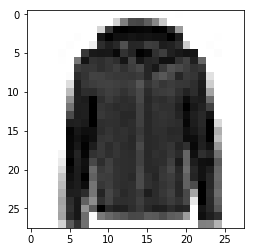

In [4]:
def show_single_image(img_dir):
    plt.imshow(img_dir, cmap="binary")
    plt.show()

show_single_image(x_train[0])


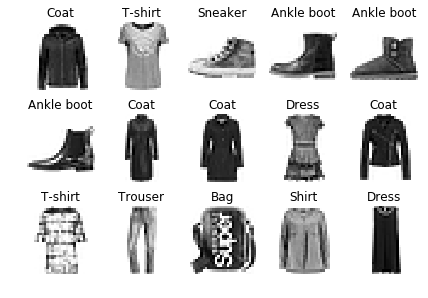

In [5]:
def show_imgs(n_rows, n_cols, x_data, y_data, class_names):
    """
    指定行列个数，显示数据集中的n_rows*n_cols个样本图像
    """
    assert len(x_data) == len(y_data)
    assert n_rows * n_cols < len(x_data)
    plt.figure(figsize = (n_cols * 1.4, n_rows * 1.6))
    for row in range(n_rows):
        for col in range(n_cols):
            index = n_cols * row + col
            plt.subplot(n_rows, n_cols, index + 1)
            plt.imshow(x_data[index], cmap="binary", interpolation = "nearest")
            plt.axis('off')
            plt.title(class_names[y_data[index]])
    plt.show()

# 指定类别
class_names = ['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
# 查看15个样本图片
show_imgs(3, 5, x_train, y_train, class_names)

In [13]:
# x = (x - u) / std

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
# x_train: [None, 28, 28] -> [None, 784]
# 此处采用fit_transform是因为，该函数可以将训练集的均值和方差记录下来，这样在验证集和测试集可以保持一致，这样也就保证了数据是同分布的，模型的构建和训练才会有效
x_train_scaled = scaler.fit_transform(
    x_train.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)
x_valid_scaled = scaler.transform(
    x_valid.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)
x_test_scaled = scaler.transform(
    x_test.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)

In [14]:
# tf.keras.models.Sequential()


model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax"))

"""
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation='relu'),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])
"""
# relu: y = max(0, x)
# softmax: 将向量变成概率分布. x = [x1, x2, x3], 
#          y = [e^x1/sum, e^x2/sum, e^x3/sum], sum = e^x1 + e^x2 + e^x3

# reason for sparse: y->index. y->one_hot->[] 
# 由于此处的数据类型y是一个数，所以此处使用sparse_categorical_crossentropy，如果y是one_hot向量，那么此处使用categorical_crossentropy
model.compile(loss="sparse_categorical_crossentropy",
              optimizer = "sgd",
              metrics = ["accuracy"])

In [15]:
model.layers

In [16]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 300)               235500    
_________________________________________________________________
dense_4 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_5 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


In [29]:
# [None, 784] * W + b -> [None, 300] W.shape [784, 300], b = [300]

In [17]:
x_train.shape,y_train.shape

((55000, 28, 28), (55000,))

In [18]:
history = model.fit(x_train_scaled, y_train, epochs=10,validation_split=False,batch_size=64,validation_data=(x_valid_scaled, y_valid))

Epoch 1/10
860/860 [==============================] - 3s 3ms/step - loss: 0.6042 - accuracy: 0.7915 - val_loss: 0.4410 - val_accuracy: 0.8502
Epoch 2/10
860/860 [==============================] - 3s 4ms/step - loss: 0.4267 - accuracy: 0.8488 - val_loss: 0.4055 - val_accuracy: 0.8594
Epoch 3/10
860/860 [==============================] - 3s 3ms/step - loss: 0.3868 - accuracy: 0.8613 - val_loss: 0.3808 - val_accuracy: 0.8642
Epoch 4/10
860/860 [==============================] - 3s 3ms/step - loss: 0.3632 - accuracy: 0.8701 - val_loss: 0.3714 - val_accuracy: 0.8674
Epoch 5/10
860/860 [==============================] - 3s 3ms/step - loss: 0.3455 - accuracy: 0.8752 - val_loss: 0.3639 - val_accuracy: 0.8710
Epoch 6/10
860/860 [==============================] - 3s 3ms/step - loss: 0.3310 - accuracy: 0.8820 - val_loss: 0.3433 - val_accuracy: 0.8756
Epoch 7/10
860/860 [==============================] - 3s 3ms/step - loss: 0.3167 - accuracy: 0.8874 - val_loss: 0.3427 - val_accuracy: 0.8776
Epoch 

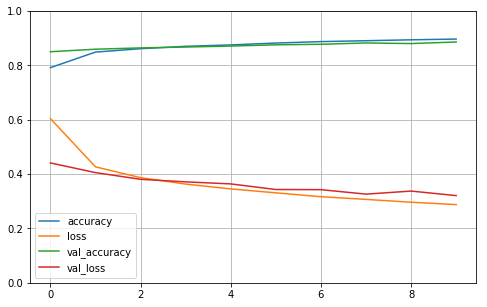

In [19]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()

plot_learning_curves(history)

In [22]:
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

313/313 - 1s - loss: 19.6928 - accuracy: 0.7925

Test accuracy: 0.7925000190734863


In [24]:
predictions = model.predict(x_test)

In [25]:
predictions[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.], dtype=float32)

In [29]:
np.argmax(predictions[0])

9

In [30]:
y_test[0]

9

In [39]:
def plot_image(i, predicitons_array, true_label, img):
    predicitons_array, true_label, img = predicitons_array, true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    plt.imshow(img, cmap=plt.cm.binary)
    
    predicitons_label = np.argmax(predicitons_array)
    if predicitons_label == true_label:
        color = 'blue'
    else:
        color = 'red'
    
    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicitons_label],
                                        100 * np.max(predicitons_array),
                                        class_names[true_label],
                                        color=color))
    
def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array, true_label[i]
    plt.grid(False)
    plt.xticks(range(10))
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicitons_label = np.argmax(predictions_array)

    thisplot[predicitons_label].set_color('red')
    thisplot[true_label].set_color('blue')

### 验证预测结果
在模型经过训练后，您可以使用它对一些图像进行预测。

我们来看看第 0 个图像、预测结果和预测数组。正确的预测标签为蓝色，错误的预测标签为红色。数字表示预测标签的百分比（总计为 100）。

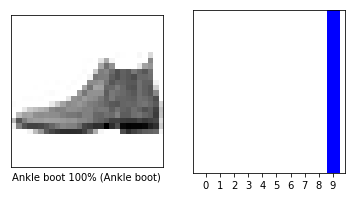

In [40]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], y_test, x_test)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i], y_test)
plt.show()

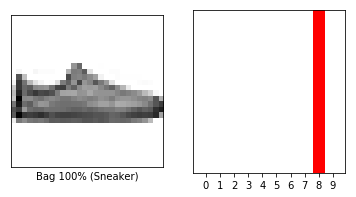

In [43]:
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], y_test, x_test)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i], y_test)
plt.show()

### 让我们用模型的预测绘制几张图像。请注意，即使置信度很高，模型也可能出错。

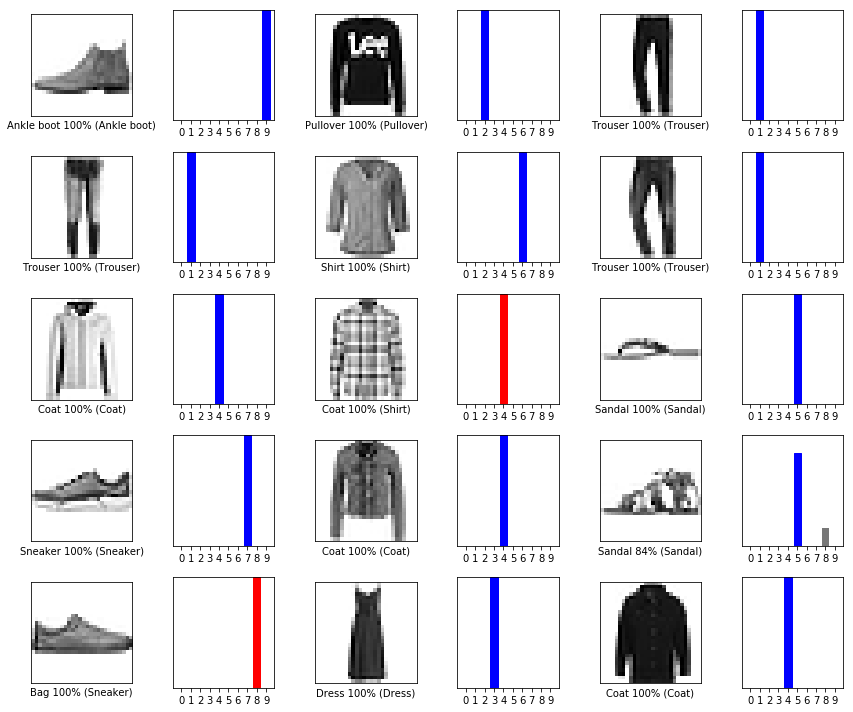

In [44]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, predictions[i], y_test, x_test)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions[i], y_test)
plt.tight_layout()
plt.show()

### 使用训练好的模型
最后，使用训练好的模型对单个图像进行预测。

In [45]:
img = x_test[1]
print(img.shape)

(28, 28)


In [46]:
# Add the image to a batch where it's the only member
img = (np.expand_dims(img, 0))

print(img.shape)

(1, 28, 28)


In [47]:
predictions_single = model.predict(img)

print(predictions_single)

[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]


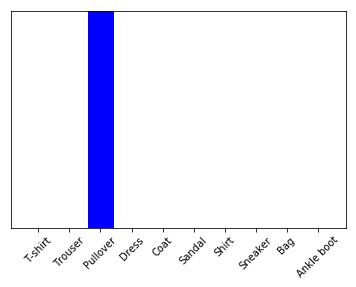

In [48]:
plot_value_array(1, predictions_single[0], y_test)
_ = plt.xticks(range(10), class_names, rotation=45)

### keras.Model.predict 会返回一组列表，每个列表对应一批数据中的每个图像。在批次中获取对我们（唯一）图像的预测：

In [49]:
np.argmax(predictions_single[0])

2